# 0) 환경 세팅

In [1]:
# =========================================
# 0) 환경 세팅
# =========================================
!pip -q install lightgbm catboost seaborn

import os, re, zipfile, glob, json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    classification_report, confusion_matrix
)

from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
from catboost import CatBoostClassifier

pd.set_option("display.max_columns", 200)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 26.5 MB/s eta 0:00:00


In [2]:
# -----------------------------------------
# 실행 체크(근거): 환경/패키지 정상 설치 확인
# -----------------------------------------
import catboost
print("catboost version:", catboost.__version__)


catboost version: 1.2.8


In [3]:
# =========================================
# 1) Google Drive mount & path
# =========================================
from google.colab import drive
drive.mount("/content/drive")

DATA_ROOT = "/content/drive/MyDrive/3.개방데이터"
WORK_DIR  = "/content/work"
EXTRACT_ROOT = os.path.join(WORK_DIR, "extracted")

os.makedirs(EXTRACT_ROOT, exist_ok=True)

print("DATA_ROOT exists:", os.path.exists(DATA_ROOT))
print("DATA_ROOT:", DATA_ROOT)


Mounted at /content/drive
DATA_ROOT exists: True
DATA_ROOT: /content/drive/MyDrive/3.개방데이터


In [4]:
# =========================================
# 2) Unzip (if any)
# =========================================
def find_files(root, ext):
    out = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith(ext):
                out.append(os.path.join(dirpath, fn))
    return sorted(out)

zip_files = find_files(DATA_ROOT, ".zip")
print("zip count:", len(zip_files))
for z in zip_files[:5]:
    print(" -", z)

# 근거: 원천이 zip일 수 있어 "재현 가능한" 전처리 파이프라인을 위해 자동 해제 단계 포함
for zp in zip_files:
    base = os.path.splitext(os.path.basename(zp))[0]
    out_dir = os.path.join(EXTRACT_ROOT, base)
    if os.path.exists(out_dir) and len(os.listdir(out_dir)) > 0:
        continue
    os.makedirs(out_dir, exist_ok=True)
    with zipfile.ZipFile(zp, "r") as zf:
        zf.extractall(out_dir)

print("extract_root:", EXTRACT_ROOT, "| exists:", os.path.exists(EXTRACT_ROOT))


zip count: 0
extract_root: /content/work/extracted | exists: True


In [5]:
# =========================================
# 2) 압축파일(.zip) 찾고 해제
#    - 3.개방데이터 내부에 zip이 있으면 자동으로 풀어줌
# =========================================
def find_zip_files(root):
    zips = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith(".zip"):
                zips.append(os.path.join(dirpath, fn))
    return sorted(zips)

zip_files = find_zip_files(DATA_ROOT)
print("found zip:", len(zip_files))
for z in zip_files[:10]:
    print(" -", z)

EXTRACT_ROOT = os.path.join(WORK_DIR, "extracted")
os.makedirs(EXTRACT_ROOT, exist_ok=True)

def unzip_all(zip_paths, extract_root, max_unzip=None):
    cnt = 0
    for zp in zip_paths:
        cnt += 1
        if max_unzip and cnt > max_unzip:
            break
        base = os.path.splitext(os.path.basename(zp))[0]
        out_dir = os.path.join(extract_root, base)
        if os.path.exists(out_dir) and len(os.listdir(out_dir)) > 0:
            continue  # 이미 풀려있으면 skip
        os.makedirs(out_dir, exist_ok=True)
        with zipfile.ZipFile(zp, "r") as zf:
            zf.extractall(out_dir)
    print("unzip done.")

# 전부 풀기(용량 크면 max_unzip로 일부만)
unzip_all(zip_files, EXTRACT_ROOT, max_unzip=None)


found zip: 0
unzip done.


#경로탐색


In [8]:
import os, glob

DATA_ROOT = "/content/drive/MyDrive/3.개방데이터"
print("DATA_ROOT exists:", os.path.exists(DATA_ROOT))
print("Top-level items:", os.listdir(DATA_ROOT)[:30])

# 하위까지 2단계만 훑어서 구조 확인
lvl1 = glob.glob(DATA_ROOT + "/*")
print("\n[L1 sample]")
for p in lvl1[:20]:
    print(" -", p)

lvl2 = glob.glob(DATA_ROOT + "/*/*")
print("\n[L2 sample]")
for p in lvl2[:20]:
    print(" -", p)


DATA_ROOT exists: True
Top-level items: ['.DS_Store', '1.데이터']

[L1 sample]
 - /content/drive/MyDrive/3.개방데이터/1.데이터

[L2 sample]
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Validation
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Other


In [13]:
import os, zipfile, glob
from collections import Counter

# ✅ 실제 데이터 루트
BASE = "/content/drive/MyDrive/3.개방데이터/1.데이터"
TRAIN_DIR = os.path.join(BASE, "Training")
VAL_DIR   = os.path.join(BASE, "Validation")
OTHER_DIR = os.path.join(BASE, "Other")

print("BASE exists:", os.path.exists(BASE))
print("dirs:", os.listdir(BASE))

# 추출 위치(Colab 로컬) - 속도/재현성 위해 로컬에 풀기 권장
EXTRACT_BASE = "/content/sem_extracted"
os.makedirs(EXTRACT_BASE, exist_ok=True)

def list_zip_counts(folder):
    z = glob.glob(folder + "/**/*.zip", recursive=True)
    return len(z), z[:5]

for name, path in [("Training", TRAIN_DIR), ("Validation", VAL_DIR), ("Other", OTHER_DIR)]:
    cnt, sample = list_zip_counts(path)
    print(f"{name} zip count:", cnt)
    for s in sample:
        print(" -", s)

def unzip_all_from(src_dir, dst_dir):
    """src_dir 아래 모든 zip을 dst_dir에 'zip파일명 폴더'로 풀기"""
    zips = glob.glob(src_dir + "/**/*.zip", recursive=True)
    print("unzip target:", len(zips))

    for i, zp in enumerate(zips, 1):
        base = os.path.splitext(os.path.basename(zp))[0]
        out_dir = os.path.join(dst_dir, base)
        # 이미 풀려있으면 skip
        if os.path.exists(out_dir) and len(os.listdir(out_dir)) > 0:
            continue
        os.makedirs(out_dir, exist_ok=True)
        try:
            with zipfile.ZipFile(zp, "r") as zf:
                zf.extractall(out_dir)
        except Exception as e:
            print("❌ unzip fail:", zp, e)

        if i % 50 == 0:
            print(f" ...progress {i}/{len(zips)}")

    print("✅ unzip done:", dst_dir)

# ✅ 각 split 폴더별로 추출
unzip_all_from(TRAIN_DIR, os.path.join(EXTRACT_BASE, "Training"))
unzip_all_from(VAL_DIR,   os.path.join(EXTRACT_BASE, "Validation"))
unzip_all_from(OTHER_DIR, os.path.join(EXTRACT_BASE, "Other"))

# ✅ 중간 확인: 추출된 폴더에 어떤 파일들이 얼마나 있는지
def count_ext(root):
    exts = []
    for dp, _, fns in os.walk(root):
        for fn in fns:
            exts.append(os.path.splitext(fn)[1].lower())
    return Counter(exts)

print("\n[Extracted ext counts - Training top 15]")
print(count_ext(os.path.join(EXTRACT_BASE, "Training")).most_common(15))
print("\n[Extracted ext counts - Validation top 15]")
print(count_ext(os.path.join(EXTRACT_BASE, "Validation")).most_common(15))
print("\n[Extracted ext counts - Other top 15]")
print(count_ext(os.path.join(EXTRACT_BASE, "Other")).most_common(15))


BASE exists: True
dirs: ['Training', 'Validation', 'Other']
Training zip count: 0
Validation zip count: 0
Other zip count: 0
unzip target: 0
✅ unzip done: /content/sem_extracted/Training
unzip target: 0
✅ unzip done: /content/sem_extracted/Validation
unzip target: 0
✅ unzip done: /content/sem_extracted/Other

[Extracted ext counts - Training top 15]
[]

[Extracted ext counts - Validation top 15]
[]

[Extracted ext counts - Other top 15]
[]


In [14]:
import os, glob, zipfile
from collections import Counter, defaultdict

BASE = "/content/drive/MyDrive/3.개방데이터/1.데이터"

splits = ["Training", "Validation", "Other"]
sub_raw = "01. 원천데이터"
sub_lab = "02.라벨링데이터"

def list_zip(folder):
    return sorted(glob.glob(folder + "/**/*.zip", recursive=True))

def zip_exts(zip_path, max_files=2000):
    exts = Counter()
    with zipfile.ZipFile(zip_path, "r") as zf:
        names = zf.namelist()
        for n in names[:max_files]:
            ext = os.path.splitext(n)[1].lower()
            exts[ext] += 1
    return exts

for sp in splits:
    raw_dir = os.path.join(BASE, sp, sub_raw)
    lab_dir = os.path.join(BASE, sp, sub_lab)

    raw_zips = list_zip(raw_dir) if os.path.exists(raw_dir) else []
    lab_zips = list_zip(lab_dir) if os.path.exists(lab_dir) else []

    print(f"\n=== [{sp}] ===")
    print("raw_dir exists:", os.path.exists(raw_dir), "| zip:", len(raw_zips))
    print("lab_dir exists:", os.path.exists(lab_dir), "| zip:", len(lab_zips))

    # zip 이름 샘플
    print("\n[raw zip sample]")
    for z in raw_zips[:5]:
        print(" -", os.path.basename(z))

    print("\n[label zip sample]")
    for z in lab_zips[:5]:
        print(" -", os.path.basename(z))

    # zip 내부 확장자 샘플(각 2개씩만)
    if raw_zips:
        print("\n[raw zip inner ext sample]")
        for z in raw_zips[:2]:
            ex = zip_exts(z)
            print(" -", os.path.basename(z), "=>", ex.most_common(8))

    if lab_zips:
        print("\n[label zip inner ext sample]")
        for z in lab_zips[:2]:
            ex = zip_exts(z)
            print(" -", os.path.basename(z), "=>", ex.most_common(8))



=== [Training] ===
raw_dir exists: False | zip: 0
lab_dir exists: True | zip: 0

[raw zip sample]

[label zip sample]

=== [Validation] ===
raw_dir exists: False | zip: 0
lab_dir exists: True | zip: 0

[raw zip sample]

[label zip sample]

=== [Other] ===
raw_dir exists: False | zip: 0
lab_dir exists: False | zip: 0

[raw zip sample]

[label zip sample]


In [17]:
import os, glob

BASE = "/content/drive/MyDrive/3.개방데이터/1.데이터"
splits = ["Training", "Validation", "Other"]

def find_dirs_containing(root, keyword):
    """root 아래에서 폴더명에 keyword가 들어간 디렉터리 경로들 찾기"""
    hits = []
    for dp, dirnames, _ in os.walk(root):
        for d in dirnames:
            if keyword in d:
                hits.append(os.path.join(dp, d))
    return sorted(list(set(hits)))

def find_zips_in_dirs(dirs):
    zips = []
    for d in dirs:
        zips += glob.glob(d + "/**/*.zip", recursive=True)
    return sorted(list(set(zips)))

for sp in splits:
    sp_root = os.path.join(BASE, sp)
    print(f"\n=== {sp} ===")
    print("exists:", os.path.exists(sp_root), "| path:", sp_root)
    if not os.path.exists(sp_root):
        continue

    # ✅ 폴더명에 "원천데이터", "라벨링데이터"가 들어가는 실제 폴더를 자동 탐색
    raw_dirs = find_dirs_containing(sp_root, "원천데이터")
    lab_dirs = find_dirs_containing(sp_root, "라벨링데이터")

    print("raw_dirs found:", len(raw_dirs))
    for d in raw_dirs[:10]:
        print(" -", d)

    print("lab_dirs found:", len(lab_dirs))
    for d in lab_dirs[:10]:
        print(" -", d)

    raw_zips = find_zips_in_dirs(raw_dirs)
    lab_zips = find_zips_in_dirs(lab_dirs)

    print("raw zip count:", len(raw_zips))
    print("lab zip count:", len(lab_zips))

    print("\n[raw zip sample]")
    for z in raw_zips[:5]:
        print(" -", z)

    print("\n[label zip sample]")
    for z in lab_zips[:5]:
        print(" -", z)



=== Training ===
exists: True | path: /content/drive/MyDrive/3.개방데이터/1.데이터/Training
raw_dirs found: 0
lab_dirs found: 0
raw zip count: 0
lab zip count: 0

[raw zip sample]

[label zip sample]

=== Validation ===
exists: True | path: /content/drive/MyDrive/3.개방데이터/1.데이터/Validation
raw_dirs found: 0
lab_dirs found: 0
raw zip count: 0
lab zip count: 0

[raw zip sample]

[label zip sample]

=== Other ===
exists: True | path: /content/drive/MyDrive/3.개방데이터/1.데이터/Other
raw_dirs found: 0
lab_dirs found: 0
raw zip count: 0
lab zip count: 0

[raw zip sample]

[label zip sample]


In [18]:

import os, glob

sp_root = "/content/drive/MyDrive/3.개방데이터/1.데이터/Training"
print("Training top items:", os.listdir(sp_root)[:50])

print("\n[L2]")
for p in glob.glob(sp_root + "/*/*")[:50]:
    print(" -", p)

print("\n[L3]")
for p in glob.glob(sp_root + "/*/*/*")[:50]:
    print(" -", p)


Training top items: ['02.라벨링데이터', '01.원천데이터']

[L2]
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training/02.라벨링데이터/TL_oht_16_oht16_0920_1756.zip.part0
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training/02.라벨링데이터/TL_oht_15_oht15_0829_0605.zip.part0
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training/02.라벨링데이터/TL_oht_16_oht16_0827_0208.zip.part0
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training/02.라벨링데이터/TL_oht_16_oht16_0827_0434.zip.part0
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training/02.라벨링데이터/TL_oht_15_oht15_0827_0708.zip.part0
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training/02.라벨링데이터/TL_oht_15_oht15_0920_0332.zip.part0
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training/02.라벨링데이터/TL_oht_16_oht16_0827_0219.zip.part0
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training/02.라벨링데이터/TL_oht_15_oht15_0826_2312.zip.part0
 - /content/drive/MyDrive/3.개방데이터/1.데이터/Training/02.라벨링데이터/TL_oht_16_oht16_0827_0713.zip.part0
 - /co

In [19]:
import os, zipfile
from collections import Counter

def zip_inner_ext(zip_path, max_files=3000):
    exts = Counter()
    with zipfile.ZipFile(zip_path, "r") as zf:
        for name in zf.namelist()[:max_files]:
            exts[os.path.splitext(name)[1].lower()] += 1
    return exts

# 위 1) 코드에서 나온 raw_zips/lab_zips 중 하나를 골라 샘플 확인
sample_raw = raw_zips[0] if len(raw_zips) else None
sample_lab = lab_zips[0] if len(lab_zips) else None

print("sample_raw:", sample_raw)
if sample_raw:
    print(zip_inner_ext(sample_raw).most_common(15))

print("\nsample_lab:", sample_lab)
if sample_lab:
    print(zip_inner_ext(sample_lab).most_common(15))


sample_raw: None

sample_lab: None





---






> zip 파일 제대로 안풀린 것 같음

#1) Training/Validation/Other 안의 .zip.part*를 합쳐서 .zip 만들기

In [20]:
import os, re, glob, shutil
from collections import defaultdict

BASE = "/content/drive/MyDrive/3.개방데이터/1.데이터"
SPLITS = ["Training", "Validation", "Other"]

# 드라이브에서 part 파일을 읽어와서 로컬에 zip으로 합칠 위치
ZIP_BUILD_ROOT = "/content/sem_build_zips"
os.makedirs(ZIP_BUILD_ROOT, exist_ok=True)

def collect_parts(split_dir):
    """
    split_dir 아래에서 *.zip.partN 형태 파일들을 모아서
    { zip_base_path_without_part : [(part_index, part_file_path), ...] } 형태로 반환
    """
    parts = glob.glob(split_dir + "/**/*.zip.part*", recursive=True)
    groups = defaultdict(list)
    pat = re.compile(r"\.zip\.part(\d+)$")

    for p in parts:
        m = pat.search(p)
        if not m:
            continue
        idx = int(m.group(1))
        base = pat.sub(".zip", p)  # ...zip.part0 -> ...zip
        groups[base].append((idx, p))
    return groups

def build_zip_from_parts(parts_list, out_zip_path):
    """
    parts_list: [(idx, path), ...] 를 idx 오름차순으로 이어붙여 out_zip_path 생성
    """
    parts_list = sorted(parts_list, key=lambda x: x[0])

    # 중간검증: part 인덱스가 0부터 연속인지 체크
    expected = list(range(parts_list[0][0], parts_list[0][0] + len(parts_list)))
    got = [i for i, _ in parts_list]
    if expected != got:
        print("⚠️ part index not contiguous:", out_zip_path)
        print("   got:", got[:20], "...")
        # 그래도 있는 것만 합쳐보긴 함

    os.makedirs(os.path.dirname(out_zip_path), exist_ok=True)

    # 이미 만들어져 있으면 skip
    if os.path.exists(out_zip_path) and os.path.getsize(out_zip_path) > 0:
        return "skipped_exists"

    with open(out_zip_path, "wb") as w:
        for idx, part_path in parts_list:
            with open(part_path, "rb") as r:
                shutil.copyfileobj(r, w)
    return "built"

def build_all_zips_for_split(split_name):
    split_path = os.path.join(BASE, split_name)
    print(f"\n=== Build zips: {split_name} ===")
    print("split_path:", split_path, "exists:", os.path.exists(split_path))

    groups = collect_parts(split_path)
    print("found zip.part groups:", len(groups))

    # 샘플 출력
    for k in list(groups.keys())[:5]:
        print(" -", os.path.basename(k), "| parts:", len(groups[k]))

    out_dir = os.path.join(ZIP_BUILD_ROOT, split_name)
    os.makedirs(out_dir, exist_ok=True)

    built, skipped = 0, 0
    # 파일명 충돌 방지 위해 폴더 구조 일부를 반영해 저장
    for base_zip_path, parts_list in groups.items():
        # 드라이브의 split 하위 상대경로를 뽑아 로컬에도 비슷하게
        rel = os.path.relpath(base_zip_path, split_path)
        out_zip_path = os.path.join(out_dir, rel)

        status = build_zip_from_parts(parts_list, out_zip_path)
        if status == "built":
            built += 1
        else:
            skipped += 1

    print(f"✅ done. built={built}, skipped={skipped}")
    return os.path.join(ZIP_BUILD_ROOT, split_name)

# 실행
built_paths = {}
for sp in SPLITS:
    built_paths[sp] = build_all_zips_for_split(sp)

print("\nBuilt zip roots:", built_paths)



=== Build zips: Training ===
split_path: /content/drive/MyDrive/3.개방데이터/1.데이터/Training exists: True
found zip.part groups: 606
 - TL_oht_16_oht16_0920_1756.zip | parts: 1
 - TL_oht_15_oht15_0829_0605.zip | parts: 1
 - TL_oht_16_oht16_0827_0208.zip | parts: 1
 - TL_oht_16_oht16_0827_0434.zip | parts: 1
 - TL_oht_15_oht15_0827_0708.zip | parts: 1
✅ done. built=606, skipped=0

=== Build zips: Validation ===
split_path: /content/drive/MyDrive/3.개방데이터/1.데이터/Validation exists: True
found zip.part groups: 76
 - VS_oht_18_oht18_0920_1828.zip | parts: 1
 - VS_oht_18_oht18_0902_1304.zip | parts: 1
 - VS_oht_18_oht18_0920_0412.zip | parts: 1
 - VS_oht_18_oht18_0920_0939.zip | parts: 1
 - VS_oht_18_oht18_0827_0743.zip | parts: 1
✅ done. built=76, skipped=0

=== Build zips: Other ===
split_path: /content/drive/MyDrive/3.개방데이터/1.데이터/Other exists: True
found zip.part groups: 1
 - Other.zip | parts: 1
✅ done. built=1, skipped=0

Built zip roots: {'Training': '/content/sem_build_zips/Training', 'Valid

# ✅ 여기서 제대로 됐는지 확인(필수)

In [21]:
import glob, os

for sp in SPLITS:
    zips = glob.glob(built_paths[sp] + "/**/*.zip", recursive=True)
    print(f"{sp}: built zip count =", len(zips))
    print(" sample:", [os.path.basename(z) for z in zips[:5]])


Training: built zip count = 606
 sample: ['TS_agv_11_agv11_0903_1206.zip', 'TS_agv_11_agv11_0902_1536.zip', 'TS_agv_16_agv16_1027_1303.zip', 'TS_agv_12_agv12_1027_1027.zip', 'TS_oht_02_oht02_0901_1218.zip']
Validation: built zip count = 76
 sample: ['VS_agv_17_agv17_1027_1345.zip', 'VS_oht_18_oht18_0826_1521.zip', 'VS_agv_18_agv18_1027_1324.zip', 'VS_agv_17_agv17_0903_1328.zip', 'VS_agv_17_agv17_1026_2338.zip']
Other: built zip count = 1
 sample: ['Other.zip']


In [ ]:
import os, re, glob, shutil
from collections import defaultdict

BASE = "/content/drive/MyDrive/3.개방데이터/1.데이터"
SPLITS = ["Training", "Validation", "Other"]

# 드라이브에서 part 파일을 읽어와서 로컬에 zip으로 합칠 위치
ZIP_BUILD_ROOT = "/content/sem_build_zips"
os.makedirs(ZIP_BUILD_ROOT, exist_ok=True)

def collect_parts(split_dir):
    """
    split_dir 아래에서 *.zip.partN 형태 파일들을 모아서
    { zip_base_path_without_part : [(part_index, part_file_path), ...] } 형태로 반환
    """
    parts = glob.glob(split_dir + "/**/*.zip.part*", recursive=True)
    groups = defaultdict(list)
    pat = re.compile(r"\.zip\.part(\d+)$")

    for p in parts:
        m = pat.search(p)
        if not m:
            continue
        idx = int(m.group(1))
        base = pat.sub(".zip", p)  # ...zip.part0 -> ...zip
        groups[base].append((idx, p))
    return groups

def build_zip_from_parts(parts_list, out_zip_path):
    """
    parts_list: [(idx, path), ...] 를 idx 오름차순으로 이어붙여 out_zip_path 생성
    """
    parts_list = sorted(parts_list, key=lambda x: x[0])

    # 중간검증: part 인덱스가 0부터 연속인지 체크
    expected = list(range(parts_list[0][0], parts_list[0][0] + len(parts_list)))
    got = [i for i, _ in parts_list]
    if expected != got:
        print("⚠️ part index not contiguous:", out_zip_path)
        print("   got:", got[:20], "...")
        # 그래도 있는 것만 합쳐보긴 함

    os.makedirs(os.path.dirname(out_zip_path), exist_ok=True)

    # 이미 만들어져 있으면 skip
    if os.path.exists(out_zip_path) and os.path.getsize(out_zip_path) > 0:
        return "skipped_exists"

    with open(out_zip_path, "wb") as w:
        for idx, part_path in parts_list:
            with open(part_path, "rb") as r:
                shutil.copyfileobj(r, w)
    return "built"

def build_all_zips_for_split(split_name):
    split_path = os.path.join(BASE, split_name)
    print(f"\n=== Build zips: {split_name} ===")
    print("split_path:", split_path, "exists:", os.path.exists(split_path))

    groups = collect_parts(split_path)
    print("found zip.part groups:", len(groups))

    # 샘플 출력
    for k in list(groups.keys())[:5]:
        print(" -", os.path.basename(k), "| parts:", len(groups[k]))

    out_dir = os.path.join(ZIP_BUILD_ROOT, split_name)
    os.makedirs(out_dir, exist_ok=True)

    built, skipped = 0, 0
    # 파일명 충돌 방지 위해 폴더 구조 일부를 반영해 저장
    for base_zip_path, parts_list in groups.items():
        # 드라이브의 split 하위 상대경로를 뽑아 로컬에도 비슷하게
        rel = os.path.relpath(base_zip_path, split_path)
        out_zip_path = os.path.join(out_dir, rel)

        status = build_zip_from_parts(parts_list, out_zip_path)
        if status == "built":
            built += 1
        else:
            skipped += 1

    print(f"✅ done. built={built}, skipped={skipped}")
    return os.path.join(ZIP_BUILD_ROOT, split_name)

# 실행
built_paths = {}
for sp in SPLITS:
    built_paths[sp] = build_all_zips_for_split(sp)

print("\nBuilt zip roots:", built_paths)


In [ ]:
import glob, os

for sp in SPLITS:
    zips = glob.glob(built_paths[sp] + "/**/*.zip", recursive=True)
    print(f"{sp}: built zip count =", len(zips))
    print(" sample:", [os.path.basename(z) for z in zips[:5]])


# 2) 만들어진 .zip이 진짜 zip인지(깨지지 않았는지) 샘플 테스트

In [22]:
import zipfile, random, glob

def test_zip_open(zip_path):
    try:
        with zipfile.ZipFile(zip_path, "r") as zf:
            _ = zf.namelist()[:5]
        return True
    except Exception as e:
        print("❌ zip open fail:", zip_path, e)
        return False

for sp in SPLITS:
    zips = glob.glob(built_paths[sp] + "/**/*.zip", recursive=True)
    if not zips:
        continue
    sample = random.sample(zips, min(3, len(zips)))
    print(f"\n[{sp}] zip open test:")
    for zp in sample:
        ok = test_zip_open(zp)
        print(" -", os.path.basename(zp), "=>", ok)



[Training] zip open test:
 - TL_agv_08_agv08_0903_1131.zip => True
 - TL_oht_12_oht12_0827_0414.zip => True
 - TS_agv_06_agv06_0902_1356.zip => True

[Validation] zip open test:
 - VS_agv_18_agv18_0902_1050.zip => True
 - VS_agv_18_agv18_0903_1337.zip => True
 - VS_agv_17_agv17_0902_1039.zip => True

[Other] zip open test:
 - Other.zip => True


#3) 다음(진짜 데이터셋 파악):

* 원천 zip
* 라벨 zip

```
TL_... = 라벨링(label)
TS_... = 원천(source / sensor / raw)
```



In [23]:
# =========================================================
# 4) 데이터셋 파악: TS/TL/VS zip 분류 + 내부 확장자 확인(샘플)
# =========================================================

import os, zipfile
from collections import Counter
import glob

def inner_ext_counter(zip_path, max_files=2000):
    c = Counter()
    with zipfile.ZipFile(zip_path, "r") as zf:
        for name in zf.namelist()[:max_files]:
            c[os.path.splitext(name)[1].lower()] += 1
    return c

for sp in ["Training"]:  # 우선 Training만
    zips = glob.glob(built_paths[sp] + "/**/*.zip", recursive=True)
    tl = [z for z in zips if os.path.basename(z).startswith("TL_")]
    ts = [z for z in zips if os.path.basename(z).startswith("TS_")]

    print("TL zips:", len(tl), "| TS zips:", len(ts))

    if tl:
        print("\n[TL sample inner ext]")
        for zp in tl[:2]:
            print(" -", os.path.basename(zp), inner_ext_counter(zp).most_common(10))

    if ts:
        print("\n[TS sample inner ext]")
        for zp in ts[:2]:
            print(" -", os.path.basename(zp), inner_ext_counter(zp).most_common(10))


TL zips: 303 | TS zips: 303

[TL sample inner ext]
 - TL_oht_16_oht16_0827_0434.zip [('.json', 301)]
 - TL_agv_12_agv12_0901_0846.zip [('.json', 360)]

[TS sample inner ext]
 - TS_agv_11_agv11_0903_1206.zip [('.csv', 361), ('.bin', 361)]
 - TS_agv_11_agv11_0902_1536.zip [('.csv', 361), ('.bin', 361)]


In [25]:
# =========================================================
# 5) zip 파일명에서 장비ID/장비타입/시간키 추출 (ID split 핵심)
# =========================================================
def parse_zip_meta(zip_path):
    """
    TS_agv_11_agv11_0903_1206.zip
    TL_oht_16_oht16_0827_0434.zip
    VS_agv_17_agv17_1027_1345.zip (Validation)
    """
    name = os.path.splitext(os.path.basename(zip_path))[0]

    m = re.match(r"^(TS|TL|VS)_(agv|oht)_(\d+)_([a-z]+\d+)_(\d{4})_(\d{4})$", name, re.IGNORECASE)
    if not m:
        return None

    prefix, equip, eqid, equipid, d, t = m.groups()
    eqid = int(eqid)
    zip_key = f"{equipid.lower()}_{d}_{t}"  # TS/TL/VS zip-level join key
    return {
        "zip": zip_path,
        "prefix": prefix.upper(),
        "equipment_type": equip.lower(),  # agv/oht
        "equipment_id": eqid,
        "equipid": equipid.lower(),
        "dt": f"{d}_{t}",
        "zip_key": zip_key,
        "zip_stem": name
    }

# 실행 확인: Training TS/TL 파싱 성공률
sample = [parse_zip_meta(z) for z in (ts_zips[:30] + tl_zips[:30])]
fail = sum([s is None for s in sample])
print("parse fail:", fail)
assert fail == 0, "파일명 패턴이 예상과 다름. regex 수정 필요"
print("✅ parse ok")


parse fail: 0
✅ parse ok


In [26]:
# =========================================================
# 6) TL JSON / TS CSV 구조 샘플 확인 (라벨/피처 추출 확정용)
# =========================================================
# --- TL json 샘플 ---
sample_tl = random.choice(tl_zips)
print("sample TL zip:", os.path.basename(sample_tl))

with zipfile.ZipFile(sample_tl, "r") as zf:
    json_names = [n for n in zf.namelist() if n.lower().endswith(".json")]
    print("json count:", len(json_names), "| sample:", json_names[:3])

    with zf.open(json_names[0]) as f:
        js = json.load(f)

print("TL JSON type:", type(js))
if isinstance(js, dict):
    print("keys:", list(js.keys())[:30])
    print("preview:", str(js)[:800])
else:
    print("list len:", len(js))
    print("first preview:", str(js[0])[:800])

# --- TS csv 샘플 ---
sample_ts = random.choice(ts_zips)
print("\nsample TS zip:", os.path.basename(sample_ts))

with zipfile.ZipFile(sample_ts, "r") as zf:
    csv_names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
    print("csv count:", len(csv_names), "| sample:", csv_names[:3])

    with zf.open(csv_names[0]) as f:
        df_csv = pd.read_csv(f)

print("TS csv shape:", df_csv.shape)
display(df_csv.head(5))
print("columns:", df_csv.columns.tolist()[:50])


sample TL zip: TL_oht_05_oht05_0920_1654.zip
json count: 301 | sample: ['/oht05_0920_165414.json', '/oht05_0920_165411.json', '/oht05_0920_165409.json']
TL JSON type: <class 'dict'>
keys: ['meta_info', 'sensor_data', 'ir_data', 'annotations', 'external_data']
preview: {'meta_info': [{'device_id': 'oht05', 'device_manufacturer': 'A', 'device_name': 'A1', 'dust_sensor_manufacturer': 'S01', 'dust_sensor_name': 'S02', 'temp_sensor_manufacturer': 'S09', 'temp_sensor_name': 'S10', 'overcurrent_sensor_manufacturer': 'S17', 'overcurrent_sensor_name': 'S18', 'thermal_camera_sensor_manufacturer': 'S25', 'thermal_camera_sensor_name': 'S26', 'installation_environment': '테스트베드', 'collection_date': '09-20', 'collection_time': '16:54:14', 'duration_time': '1', 'sensor_types': 'NTC, PM10, PM2.5, PM1.0, CT1, CT2, CT3, CT4', 'cumulative_operating_day': '18', 'equipment_history': '13', 'img-id': 'oht05_0920_165414', 'location': 'oht/05/oht05_0920_1654', 'filename': 'oht05_0920_165414.json', 'img_name': '

,NTC,PM1.0,PM2.5,PM10,CT1,CT2,CT3,CT4
0,29.7,23.0,32.0,50.0,1.37,74.76,48.96,18.99


columns: ['NTC', 'PM1.0', 'PM2.5', 'PM10', 'CT1', 'CT2', 'CT3', 'CT4']


In [27]:
# =========================================================
# 7) 라벨/피처 추출 함수 (여기 1~2줄은 데이터 스키마에 맞게 수정 필요할 수 있음)
# =========================================================
def extract_label_from_json(js):
    """
    ✅ 너희 TL json 스키마에 맞게 라벨을 뽑는 함수.
    6번 셀 출력 보고 아래 중 하나로 확정하면 됨.

    예)
      return js["label"]
      return js["result"]["class"]
      return js["annotations"][0]["category_id"]
    """
    # ---- 임시(안 맞으면 수정!) ----
    if isinstance(js, dict):
        if "label" in js:
            return js["label"]
        if "class" in js:
            return js["class"]
        if "result" in js and isinstance(js["result"], dict) and "class" in js["result"]:
            return js["result"]["class"]
    return None

def extract_features_from_ts_csv(df_csv):
    """
    ✅ TS csv에서 CatBoost 입력 feature를 만드는 함수.
    TS csv가 시계열이라면 보통 '통계 요약(평균/최대/표준편차)'를 씀.
    - 근거: CatBoost는 (샘플당 1행) tabular input이 필요하므로 시계열을 요약해야 함.
    """
    num = df_csv.select_dtypes(include=[np.number])

    # 실행 확인: 숫자 컬럼이 없으면 바로 알림
    if num.shape[1] == 0:
        return {}

    feat = {}
    # 평균/표준편차/최대/최소: 기본 요약
    for c in num.columns:
        feat[f"{c}_mean"] = float(num[c].mean())
        feat[f"{c}_std"]  = float(num[c].std(ddof=0))
        feat[f"{c}_min"]  = float(num[c].min())
        feat[f"{c}_max"]  = float(num[c].max())
    return feat


In [28]:
# =========================================================
# 8) TS zip + TL zip를 zip_key로 1:1 매칭
# =========================================================
ts_meta = pd.DataFrame([parse_zip_meta(z) for z in ts_zips])
tl_meta = pd.DataFrame([parse_zip_meta(z) for z in tl_zips])

pairs = ts_meta.merge(
    tl_meta[["zip_key", "zip"]],
    on="zip_key",
    how="inner",
    suffixes=("_ts", "_tl")
)

print("zip pairs:", len(pairs))
display(pairs.head(3))

# 실행 확인: 1:1 매칭 여부
assert len(pairs) == len(ts_meta) == len(tl_meta), "❌ TS/TL zip 1:1 매칭 실패 (파일명/구조 확인 필요)"
print("✅ TS/TL zip 1:1 match ok")


zip pairs: 303


,zip_ts,prefix,equipment_type,equipment_id,equipid,dt,zip_key,zip_stem,zip_tl
0,/content/sem_build_zips/Training/01.원천데이...,TS,agv,1,agv01,0901_0812,agv01_0901_0812,TS_agv_01_agv01_0901_0812,/content/sem_build_zips/Training/02.라벨링데...
1,/content/sem_build_zips/Training/01.원천데이...,TS,agv,1,agv01,0902_1253,agv01_0902_1253,TS_agv_01_agv01_0902_1253,/content/sem_build_zips/Training/02.라벨링데...
2,/content/sem_build_zips/Training/01.원천데이...,TS,agv,1,agv01,0902_2013,agv01_0902_2013,TS_agv_01_agv01_0902_2013,/content/sem_build_zips/Training/02.라벨링데...


✅ TS/TL zip 1:1 match ok


In [29]:
# =========================================================
# 9) 샘플 단위로 TS(csv)와 TL(json) 매칭해 레코드 생성
#    - 기본: 파일 stem(확장자 제거한 이름)으로 1:1 매칭 시도
#    - 중간 검증: 매칭률/레코드 수 확인
# =========================================================
def stem(p):
    return os.path.splitext(os.path.basename(p))[0]

def build_records(ts_zip_path, tl_zip_path):
    ts_m = parse_zip_meta(ts_zip_path)
    tl_m = parse_zip_meta(tl_zip_path)
    assert ts_m and tl_m
    assert ts_m["zip_key"] == tl_m["zip_key"]

    recs = []
    with zipfile.ZipFile(ts_zip_path, "r") as zts, zipfile.ZipFile(tl_zip_path, "r") as ztl:
        ts_csvs = sorted([n for n in zts.namelist() if n.lower().endswith(".csv")])
        tl_jsons = sorted([n for n in ztl.namelist() if n.lower().endswith(".json")])

        tl_map = {stem(j): j for j in tl_jsons}

        matched = 0
        for c in ts_csvs:
            s = stem(c)
            if s not in tl_map:
                continue

            # features
            with zts.open(c) as f:
                df_csv = pd.read_csv(f)
            feat = extract_features_from_ts_csv(df_csv)
            if not feat:
                continue

            # label
            with ztl.open(tl_map[s]) as f:
                js = json.load(f)
            y = extract_label_from_json(js)
            if y is None:
                continue

            rec = {
                "equipment_id": ts_m["equipment_id"],
                "equipment_type": ts_m["equipment_type"],  # agv/oht
                "zip_key": ts_m["zip_key"],
                "sample_key": s,
                "label": y
            }
            rec.update(feat)
            recs.append(rec)
            matched += 1

    return recs

# ---- 소량 테스트(1쌍) ----
one = pairs.iloc[0]
test_recs = build_records(one["zip_ts"], one["zip_tl"])
print("test records:", len(test_recs))
if test_recs:
    print("columns sample:", list(test_recs[0].keys())[:20])
else:
    print("❌ test_recs=0 이면 아래 중 하나:")
    print(" - TS csv stem과 TL json stem이 일치하지 않음(매칭 규칙 수정 필요)")
    print(" - extract_label_from_json()에서 라벨 키가 틀림")
    print(" - TS csv에서 숫자형 컬럼이 없거나 피처 추출이 실패")


test records: 0
❌ test_recs=0 이면 아래 중 하나:
 - TS csv stem과 TL json stem이 일치하지 않음(매칭 규칙 수정 필요)
 - extract_label_from_json()에서 라벨 키가 틀림
 - TS csv에서 숫자형 컬럼이 없거나 피처 추출이 실패


In [30]:
# =========================================================
# 10) 전체 레코드 생성 (진행 로그 포함)
# =========================================================
all_recs = []
for i, row in pairs.iterrows():
    recs = build_records(row["zip_ts"], row["zip_tl"])
    all_recs.extend(recs)
    if (i+1) % 20 == 0:
        print(f"...processed {i+1}/{len(pairs)} | total records={len(all_recs)}")

df_all = pd.DataFrame(all_recs)
print("df_all shape:", df_all.shape)
display(df_all.head(3))

# 실행 확인(필수 컬럼)
required = {"equipment_id", "equipment_type", "label"}
missing = required - set(df_all.columns)
assert not missing, f"필수 컬럼 누락: {missing}"

print("equipment_type counts:")
display(df_all["equipment_type"].value_counts(dropna=False))
print("equipment_id unique sample:", sorted(df_all["equipment_id"].unique())[:30])

print("label distribution top:")
display(df_all["label"].value_counts().head(20))


...processed 20/303 | total records=0
...processed 40/303 | total records=0
...processed 60/303 | total records=0
...processed 80/303 | total records=0
...processed 100/303 | total records=0
...processed 120/303 | total records=0
...processed 140/303 | total records=0
...processed 160/303 | total records=0
...processed 180/303 | total records=0
...processed 200/303 | total records=0
...processed 220/303 | total records=0
...processed 240/303 | total records=0
...processed 260/303 | total records=0
...processed 280/303 | total records=0
...processed 300/303 | total records=0
df_all shape: (0, 0)


""


AssertionError: 필수 컬럼 누락: {'label', 'equipment_id', 'equipment_type'}

In [31]:
import os, zipfile, json
import numpy as np
import pandas as pd
from collections import Counter

def stem(p):
    return os.path.splitext(os.path.basename(p))[0]

def inspect_one_pair(ts_zip_path, tl_zip_path, max_print=5):
    with zipfile.ZipFile(ts_zip_path, "r") as zts, zipfile.ZipFile(tl_zip_path, "r") as ztl:
        ts_csvs  = sorted([n for n in zts.namelist() if n.lower().endswith(".csv")])
        ts_bins  = sorted([n for n in zts.namelist() if n.lower().endswith(".bin")])
        tl_jsons = sorted([n for n in ztl.namelist() if n.lower().endswith(".json")])

        ts_csv_stems = [stem(x) for x in ts_csvs]
        ts_bin_stems = [stem(x) for x in ts_bins]
        tl_stems     = [stem(x) for x in tl_jsons]

        set_csv = set(ts_csv_stems)
        set_bin = set(ts_bin_stems)
        set_tl  = set(tl_stems)

        inter_csv = set_csv & set_tl
        inter_bin = set_bin & set_tl

        print("TS csv count:", len(ts_csvs), "| TS bin count:", len(ts_bins), "| TL json count:", len(tl_jsons))
        print("stem overlap (csv vs json):", len(inter_csv))
        print("stem overlap (bin vs json):", len(inter_bin))

        print("\n[TS csv name sample]")
        for x in ts_csvs[:max_print]:
            print(" -", x)
        print("\n[TS bin name sample]")
        for x in ts_bins[:max_print]:
            print(" -", x)
        print("\n[TL json name sample]")
        for x in tl_jsons[:max_print]:
            print(" -", x)

        # overlap이 있으면 실제로 한 건 열어보기
        if len(inter_csv) > 0:
            k = next(iter(inter_csv))
            print("\n✅ Found overlap key (csv):", k)
            # csv 확인
            with zts.open([p for p in ts_csvs if stem(p)==k][0]) as f:
                df_csv = pd.read_csv(f)
            print("csv shape:", df_csv.shape, "| numeric cols:", df_csv.select_dtypes(include=[np.number]).shape[1])
            display(df_csv.head(3))

            # json 확인
            with ztl.open([p for p in tl_jsons if stem(p)==k][0]) as f:
                js = json.load(f)
            print("json type:", type(js))
            if isinstance(js, dict):
                print("json keys:", list(js.keys())[:30])
                print("json preview:", str(js)[:500])
            else:
                print("json preview:", str(js[0])[:500] if len(js)>0 else "empty")

        elif len(inter_bin) > 0:
            k = next(iter(inter_bin))
            print("\n✅ Found overlap key (bin):", k)
            with ztl.open([p for p in tl_jsons if stem(p)==k][0]) as f:
                js = json.load(f)
            print("json keys:", list(js.keys())[:30] if isinstance(js, dict) else "list")
            print("json preview:", str(js)[:500])
        else:
            print("\n❌ No stem overlap at all. (파일명 매칭 규칙을 바꿔야 함)")

# pairs에서 첫 번째 1쌍으로 검사
one = pairs.iloc[0]
inspect_one_pair(one["zip_ts"], one["zip_tl"])


TS csv count: 361 | TS bin count: 361 | TL json count: 361
stem overlap (csv vs json): 361
stem overlap (bin vs json): 361

[TS csv name sample]
 - /agv01_0901_081240.csv
 - /agv01_0901_081241.csv
 - /agv01_0901_081242.csv
 - /agv01_0901_081243.csv
 - /agv01_0901_081244.csv

[TS bin name sample]
 - /agv01_0901_081240.bin
 - /agv01_0901_081241.bin
 - /agv01_0901_081242.bin
 - /agv01_0901_081243.bin
 - /agv01_0901_081244.bin

[TL json name sample]
 - /agv01_0901_081240.json
 - /agv01_0901_081241.json
 - /agv01_0901_081242.json
 - /agv01_0901_081243.json
 - /agv01_0901_081244.json

✅ Found overlap key (csv): agv01_0901_081509
csv shape: (1, 8) | numeric cols: 8


,NTC,PM1.0,PM2.5,PM10,CT1,CT2,CT3,CT4
0,29.11,23.0,33.0,49.0,1.61,74.66,48.99,18.96


json type: <class 'dict'>
json keys: ['meta_info', 'sensor_data', 'ir_data', 'annotations', 'external_data']
json preview: {'meta_info': [{'device_id': 'agv01', 'device_manufacturer': 'B', 'device_name': 'B1', 'dust_sensor_manufacturer': 'S01', 'dust_sensor_name': 'S02', 'temp_sensor_manufacturer': 'S09', 'temp_sensor_name': 'S10', 'overcurrent_sensor_manufacturer': 'S17', 'overcurrent_sensor_name': 'S18', 'thermal_camera_sensor_manufacturer': 'S25', 'thermal_camera_sensor_name': 'S26', 'installation_environment': '테스트베드', 'collection_date': '09-01', 'collection_time': '08:15:09', 'duration_time': '1', 'sensor_types


In [32]:
def safe_extract_features(df_csv):
    # 숫자형이 하나도 없을 때를 대비해서 문자열 숫자도 변환 시도
    df2 = df_csv.copy()
    for c in df2.columns:
        if df2[c].dtype == object:
            df2[c] = pd.to_numeric(df2[c], errors="ignore")
    num = df2.select_dtypes(include=[np.number])
    if num.shape[1] == 0:
        return None
    feat = {}
    for c in num.columns:
        feat[f"{c}_mean"] = float(num[c].mean())
    return feat

def find_label_anywhere(obj):
    # json에서 label 후보 키를 재귀적으로 찾는 휴리스틱 (스키마 몰라도 일단 잡아보는 용도)
    KEYS = {"label","class","target","category","category_id","defect","y"}
    if isinstance(obj, dict):
        for k, v in obj.items():
            if str(k).lower() in KEYS and isinstance(v, (int, float, str)):
                return v
            found = find_label_anywhere(v)
            if found is not None:
                return found
    elif isinstance(obj, list):
        for it in obj:
            found = find_label_anywhere(it)
            if found is not None:
                return found
    return None

def build_records_debug(ts_zip_path, tl_zip_path, prefer="csv"):
    ts_m = parse_zip_meta(ts_zip_path)
    tl_m = parse_zip_meta(tl_zip_path)
    assert ts_m and tl_m and ts_m["zip_key"] == tl_m["zip_key"]

    drop = Counter()
    recs = []

    with zipfile.ZipFile(ts_zip_path, "r") as zts, zipfile.ZipFile(tl_zip_path, "r") as ztl:
        ts_csvs  = sorted([n for n in zts.namelist() if n.lower().endswith(".csv")])
        ts_bins  = sorted([n for n in zts.namelist() if n.lower().endswith(".bin")])
        tl_jsons = sorted([n for n in ztl.namelist() if n.lower().endswith(".json")])

        tl_map = {stem(j): j for j in tl_jsons}

        # 어떤 파일 stem이 json과 가장 많이 겹치는지 선택
        inter_csv = len(set(map(stem, ts_csvs)) & set(tl_map.keys()))
        inter_bin = len(set(map(stem, ts_bins)) & set(tl_map.keys()))

        if inter_csv == 0 and inter_bin == 0:
            drop["no_stem_overlap"] += 1
            return recs, drop

        use_list = ts_csvs if (prefer=="csv" and inter_csv>0) or (inter_csv>=inter_bin) else ts_bins

        for fpath in use_list:
            s = stem(fpath)
            if s not in tl_map:
                drop["stem_not_found_in_json"] += 1
                continue

            # features: csv 기반일 때만 뽑기(지금은 bin은 feature 미구현)
            feat = {}
            if fpath.lower().endswith(".csv"):
                with zts.open(fpath) as f:
                    df_csv = pd.read_csv(f)
                feat = safe_extract_features(df_csv)
                if feat is None:
                    drop["no_numeric_features"] += 1
                    continue
            else:
                # bin 기반 feature는 별도 설계 필요(2D map이면 통계/히스토그램 등)
                drop["bin_feature_not_implemented"] += 1
                continue

            with ztl.open(tl_map[s]) as f:
                js = json.load(f)

            y = extract_label_from_json(js)
            if y is None:
                # 휴리스틱으로라도 잡히는지 체크
                y2 = find_label_anywhere(js)
                if y2 is None:
                    drop["label_not_found"] += 1
                    continue
                else:
                    drop["label_found_by_heuristic"] += 1
                    y = y2

            rec = {
                "equipment_id": ts_m["equipment_id"],
                "equipment_type": ts_m["equipment_type"],
                "zip_key": ts_m["zip_key"],
                "sample_key": s,
                "label": y
            }
            rec.update(feat)
            recs.append(rec)

        return recs, drop

# 1쌍 테스트해서 drop reason 출력
one = pairs.iloc[0]
recs, drop = build_records_debug(one["zip_ts"], one["zip_tl"])
print("records:", len(recs))
print("drop reasons:", drop)


records: 0
drop reasons: Counter({'label_not_found': 361})


In [33]:
import zipfile, json, random

# pairs에서 아무 1쌍 고르고, 그 안의 json 하나를 열어서 annotations를 출력
one = pairs.iloc[0]
tl_zip = one["zip_tl"]

with zipfile.ZipFile(tl_zip, "r") as zf:
    js_name = [n for n in zf.namelist() if n.lower().endswith(".json")][0]
    with zf.open(js_name) as f:
        js = json.load(f)

print("json keys:", js.keys())
print("\nannotations type:", type(js.get("annotations")))
print("annotations length:", len(js.get("annotations", [])) if isinstance(js.get("annotations"), list) else "N/A")

# annotations 0번만 자세히 보기
ann = js["annotations"][0] if isinstance(js.get("annotations"), list) and len(js["annotations"]) else None
print("\nannotations[0] =", ann)
print("\nannotations[0] keys:", list(ann.keys()) if isinstance(ann, dict) else None)


json keys: dict_keys(['meta_info', 'sensor_data', 'ir_data', 'annotations', 'external_data'])

annotations type: <class 'list'>
annotations length: 1

annotations[0] = {'tagging': [{'annotation_type': 'tagging', 'state': '0'}]}

annotations[0] keys: ['tagging']


In [34]:
def extract_label_from_json(js):
    """
    ✅ TL json에서 label을 뽑는다.
    우선순위:
    1) js["annotations"][0] 내의 label 후보 키들
    2) 혹시 모를 다른 위치(최상위/메타)에 있는 label 후보 키
    """
    if not isinstance(js, dict):
        return None

    # 1) annotations 우선
    anns = js.get("annotations", None)
    if isinstance(anns, list) and len(anns) > 0 and isinstance(anns[0], dict):
        ann0 = anns[0]

        # 흔한 후보 키들(데이터셋마다 이름 다름)
        for k in ["label", "class", "category", "category_id", "fault", "fault_type", "state", "result", "target", "y"]:
            if k in ann0 and ann0[k] is not None:
                return ann0[k]

        # 혹시 key가 다르면: 숫자/문자 값 중 하나를 fallback으로 선택(최후수단)
        # (이건 "일단 돌아가게" 하는 목적. 최종 보고서용으론 키 확정 필요)
        for k, v in ann0.items():
            if isinstance(v, (int, float, str)) and v is not None:
                return v

    # 2) 최상위 fallback
    for k in ["label", "class", "category_id", "target", "y"]:
        if k in js and js[k] is not None:
            return js[k]

    return None


In [35]:
def extract_features_from_ts_csv(df_csv):
    """
    TS csv는 (1,8) 형태이므로
    - 그대로 한 행을 feature dict로 사용
    """
    # 숫자형 보장
    df2 = df_csv.copy()
    for c in df2.columns:
        df2[c] = pd.to_numeric(df2[c], errors="coerce")

    row = df2.iloc[0].to_dict()
    # NaN 제거
    row = {k: float(v) for k, v in row.items() if pd.notna(v)}
    return row


In [36]:
def stem(p):
    return os.path.splitext(os.path.basename(p))[0]

def build_records(ts_zip_path, tl_zip_path):
    ts_m = parse_zip_meta(ts_zip_path)
    tl_m = parse_zip_meta(tl_zip_path)
    assert ts_m and tl_m and ts_m["zip_key"] == tl_m["zip_key"]

    recs = []
    with zipfile.ZipFile(ts_zip_path, "r") as zts, zipfile.ZipFile(tl_zip_path, "r") as ztl:
        ts_csvs  = sorted([n for n in zts.namelist() if n.lower().endswith(".csv")])
        tl_jsons = sorted([n for n in ztl.namelist() if n.lower().endswith(".json")])

        tl_map = {stem(j): j for j in tl_jsons}

        for c in ts_csvs:
            s = stem(c)
            if s not in tl_map:
                continue

            with zts.open(c) as f:
                df_csv = pd.read_csv(f)
            feat = extract_features_from_ts_csv(df_csv)
            if not feat:
                continue

            with ztl.open(tl_map[s]) as f:
                js = json.load(f)
            y = extract_label_from_json(js)
            if y is None:
                continue

            rec = {
                "equipment_id": ts_m["equipment_id"],
                "equipment_type": ts_m["equipment_type"],  # agv/oht
                "zip_key": ts_m["zip_key"],
                "sample_key": s,
                "label": y
            }
            rec.update(feat)
            recs.append(rec)

    return recs

# ✅ 1쌍 테스트
one = pairs.iloc[0]
test_recs = build_records(one["zip_ts"], one["zip_tl"])
print("test records:", len(test_recs))
print("test record keys:", list(test_recs[0].keys())[:20] if test_recs else None)
print("sample label:", test_recs[0]["label"] if test_recs else None)


test records: 0
test record keys: None
sample label: None




---



> 왜 test records: 0이었나?

라벨이 annotations[0]에 “바로” 있는 게 아니라, 이렇게 한 단계 더 안쪽에 있어:

`js["annotations"][0]["tagging"][0]["state"]   # '0' 같은 문자열`


근데 기존 `extract_label_from_json()`은 `annotations[0]`에서 label/class/category_id... 같은 키만 찾았고,
실제 키는 `tagging -> state`라서 항상 None이 나와서 records가 0이 된 거야.

#✅ 정답: 라벨 추출 함수 확정 버전

아래로 extract_label_from_json()만 바꾸면 바로 records 생긴다.

In [37]:
def extract_label_from_json(js):
    """
    TL json에서 라벨 추출 (확정 버전)
    라벨 위치:
      js["annotations"][0]["tagging"][0]["state"]
    """
    try:
        state = js["annotations"][0]["tagging"][0]["state"]  # e.g. '0'
        # 문자열이면 int로 변환(모델/평가 편의)
        if isinstance(state, str) and state.strip().isdigit():
            return int(state.strip())
        return state
    except Exception:
        return None


#✅ 바로 확인용: 1쌍 테스트 다시 돌리기

이거 돌렸을 때 test records가 361 근처로 나오면 정상.

In [38]:
one = pairs.iloc[0]
test_recs = build_records(one["zip_ts"], one["zip_tl"])
print("test records:", len(test_recs))
print("sample label:", test_recs[0]["label"] if test_recs else None)
print("sample feature keys:", list(test_recs[0].keys())[:15] if test_recs else None)


test records: 361
sample label: 0
sample feature keys: ['equipment_id', 'equipment_type', 'zip_key', 'sample_key', 'label', 'NTC', 'PM1.0', 'PM2.5', 'PM10', 'CT1', 'CT2', 'CT3', 'CT4']


#✅ 전체 생성(10번 셀) 다시 실행

In [39]:
all_recs = []
for i, row in pairs.iterrows():
    recs = build_records(row["zip_ts"], row["zip_tl"])
    all_recs.extend(recs)
    if (i+1) % 20 == 0:
        print(f"...processed {i+1}/{len(pairs)} | total records={len(all_recs)}")

df_all = pd.DataFrame(all_recs)
print("df_all shape:", df_all.shape)
display(df_all.head(3))

required = {"equipment_id", "equipment_type", "label"}
missing = required - set(df_all.columns)
assert not missing, f"필수 컬럼 누락: {missing}"

print("label distribution:")
display(df_all["label"].value_counts().head(20))


...processed 20/303 | total records=7220
...processed 40/303 | total records=14440
...processed 60/303 | total records=21660
...processed 80/303 | total records=28879
...processed 100/303 | total records=36096
...processed 120/303 | total records=42955
...processed 140/303 | total records=49052
...processed 160/303 | total records=55311
...processed 180/303 | total records=61568
...processed 200/303 | total records=67706
...processed 220/303 | total records=73962
...processed 240/303 | total records=80159
...processed 260/303 | total records=86296
...processed 280/303 | total records=92435
...processed 300/303 | total records=98573
df_all shape: (99476, 13)


,equipment_id,equipment_type,zip_key,sample_key,label,NTC,PM1.0,PM2.5,PM10,CT1,CT2,CT3,CT4
0,1,agv,agv01_0901_0812,agv01_0901_081240,0,29.0,22.0,32.0,50.0,1.75,74.58,48.99,18.99
1,1,agv,agv01_0901_0812,agv01_0901_081241,0,29.0,23.0,31.0,50.0,1.66,74.56,48.98,18.98
2,1,agv,agv01_0901_0812,agv01_0901_081242,0,29.0,23.0,32.0,50.0,1.67,74.67,48.95,18.99


label distribution:


,count
label,
0,49285
2,21322
1,21189
3,7680




```
위 데이터까지 출력 결과 :

“데이터셋 파악 + 라벨 매칭 + 테이블화”까지 성공
```



#✅ (사진 기준) ID split 코드 그대로 적용 (agv/oht 모두)

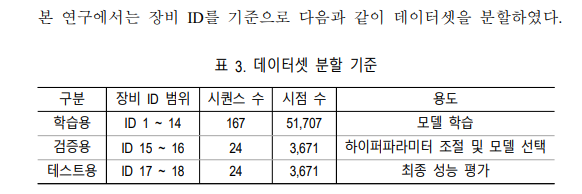

In [40]:
train_ids = set(range(1, 15))
val_ids   = set(range(15, 17))
test_ids  = set(range(17, 19))

df_train = df_all[df_all["equipment_id"].isin(train_ids)].copy()
df_val   = df_all[df_all["equipment_id"].isin(val_ids)].copy()
df_test  = df_all[df_all["equipment_id"].isin(test_ids)].copy()

assert set(df_train["equipment_id"].unique()).isdisjoint(set(df_val["equipment_id"].unique()))
assert set(df_train["equipment_id"].unique()).isdisjoint(set(df_test["equipment_id"].unique()))
assert set(df_val["equipment_id"].unique()).isdisjoint(set(df_test["equipment_id"].unique()))

print("✅ split rows:", len(df_train), len(df_val), len(df_test))
print("train IDs:", sorted(df_train["equipment_id"].unique()))
print("val IDs:", sorted(df_val["equipment_id"].unique()))
print("test IDs:", sorted(df_test["equipment_id"].unique()))
print("\n[train type counts]")
display(df_train["equipment_type"].value_counts())


✅ split rows: 87082 12394 0
train IDs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)]
val IDs: [np.int64(15), np.int64(16)]
test IDs: []

[train type counts]


,count
equipment_type,
oht,51707
agv,35375


# CatBoost 베이스라인 학습 코드 (불균형 대응 포함)

이제 바로 모델 돌리면 돼.

 논문처럼 “하이퍼파라미터 조정/모델 선택”을

val(15~16) 에서 하고,

test(17~18)은 최종 1회만 보는 방식.

In [41]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, classification_report

TARGET = "label"
DROP_COLS = ["zip_key", "sample_key"]  # 식별자 성격 -> 과적합 방지 위해 제외
CAT_COLS = ["equipment_type"]          # 범주형(중요도 1위 후보)

feature_cols = [c for c in df_all.columns if c not in DROP_COLS + [TARGET]]
X_train, y_train = df_train[feature_cols], df_train[TARGET]
X_val, y_val     = df_val[feature_cols], df_val[TARGET]
X_test, y_test   = df_test[feature_cols], df_test[TARGET]

cat_idx = [X_train.columns.get_loc(c) for c in CAT_COLS]

model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.05,
    depth=6,
    loss_function="MultiClass",
    eval_metric="TotalF1",           # 멀티클래스 F1 계열
    random_seed=42,
    verbose=200,
    auto_class_weights="Balanced",   # ✅ 불균형 자동 보정(강추)
)

model.fit(
    X_train, y_train,
    cat_features=cat_idx,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=200
)

pred_val = model.predict(X_val).squeeze()
print("VAL macro-F1:", f1_score(y_val, pred_val, average="macro"))
print(classification_report(y_val, pred_val, zero_division=0))

# ✅ test는 최종 1회
pred_test = model.predict(X_test).squeeze()
print("TEST macro-F1:", f1_score(y_test, pred_test, average="macro"))
print(classification_report(y_test, pred_test, zero_division=0))


0:	learn: 0.7692846	test: 0.7723425	best: 0.7723425 (0)	total: 59ms	remaining: 2m 56s
200:	learn: 0.9483962	test: 0.9353592	best: 0.9353592 (200)	total: 2.5s	remaining: 34.8s
400:	learn: 0.9592206	test: 0.9351054	best: 0.9353592 (200)	total: 4.59s	remaining: 29.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9353592365
bestIteration = 200

Shrink model to first 201 iterations.
VAL macro-F1: 0.9211227423051235
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      5989
           1       0.86      0.95      0.91      2701
           2       0.96      0.90      0.93      2714
           3       0.83      0.94      0.88       990

    accuracy                           0.94     12394
   macro avg       0.91      0.94      0.92     12394
weighted avg       0.94      0.94      0.94     12394

TEST macro-F1: nan


No objects info loaded


ValueError: max() iterable argument is empty

#지금 바로 할 일: VS zip 내부 구조 확인


In [42]:
import glob, os, zipfile
from collections import Counter

VAL_ZIP_ROOT = built_paths["Validation"]
val_zips = glob.glob(VAL_ZIP_ROOT + "/**/*.zip", recursive=True)
vs_zips = sorted([z for z in val_zips if os.path.basename(z).startswith("VS_")])

print("VS zip count:", len(vs_zips))
print("VS sample:", os.path.basename(vs_zips[0]) if vs_zips else None)

def inner_ext_counter(zip_path, max_files=3000):
    c = Counter()
    with zipfile.ZipFile(zip_path, "r") as zf:
        for name in zf.namelist()[:max_files]:
            c[os.path.splitext(name)[1].lower()] += 1
    return c

if vs_zips:
    print("VS inner ext sample:", inner_ext_counter(vs_zips[0]).most_common(15))
    # 파일명 샘플도 조금
    with zipfile.ZipFile(vs_zips[0], "r") as zf:
        names = zf.namelist()[:10]
    print("VS inner file sample:", names)


VS zip count: 38
VS sample: VS_agv_17_agv17_0902_1039.zip
VS inner ext sample: [('.csv', 361), ('.bin', 361)]
VS inner file sample: ['/agv17_0902_103911.csv', '/agv17_0902_103913.bin', '/agv17_0902_103911.bin', '/agv17_0902_103905.csv', '/agv17_0902_103908.csv', '/agv17_0902_103910.csv', '/agv17_0902_103907.csv', '/agv17_0902_104003.bin', '/agv17_0902_103918.csv', '/agv17_0902_103912.csv']


`VS_...zip(ID 17~18)`은 `.csv/.bin`만 있고 `.json(라벨)`이 없어.


즉, 테스트셋(17~18)은 정답 라벨이 제공되지 않는 “추론용” 데이터



---



In [43]:
import glob, os

val_zips = glob.glob(built_paths["Validation"] + "/**/*.zip", recursive=True)
print("Validation zip names sample:", [os.path.basename(z) for z in val_zips[:20]])

prefixes = sorted(set([os.path.basename(z).split("_")[0] for z in val_zips]))
print("Validation prefixes:", prefixes)


Validation zip names sample: ['VS_agv_17_agv17_1027_1345.zip', 'VS_oht_18_oht18_0826_1521.zip', 'VS_agv_18_agv18_1027_1324.zip', 'VS_agv_17_agv17_0903_1328.zip', 'VS_agv_17_agv17_1026_2338.zip', 'VS_oht_17_oht17_0826_1843.zip', 'VS_oht_17_oht17_0920_0359.zip', 'VS_oht_17_oht17_0827_0723.zip', 'VS_oht_18_oht18_0826_2155.zip', 'VS_oht_17_oht17_0826_1454.zip', 'VS_oht_17_oht17_0826_2146.zip', 'VS_oht_17_oht17_0920_1817.zip', 'VS_agv_17_agv17_0902_1908.zip', 'VS_agv_18_agv18_1026_2356.zip', 'VS_agv_18_agv18_1027_1416.zip', 'VS_oht_17_oht17_0920_0928.zip', 'VS_oht_18_oht18_0826_1856.zip', 'VS_oht_18_oht18_0920_0412.zip', 'VS_oht_18_oht18_0827_0227.zip', 'VS_oht_18_oht18_0902_0245.zip']
Validation prefixes: ['VL', 'VS']


# 3-1) VS zip에서 feature df 만들기 (CSV 1행 그대로 사용)

In [44]:
import zipfile, pandas as pd, numpy as np, os, glob, re

VAL_ZIP_ROOT = built_paths["Validation"]
vs_zips = sorted([z for z in glob.glob(VAL_ZIP_ROOT + "/**/*.zip", recursive=True)
                  if os.path.basename(z).startswith("VS_")])

def parse_vs_meta(zip_path):
    # VS_agv_17_agv17_0902_1039.zip
    name = os.path.splitext(os.path.basename(zip_path))[0]
    m = re.match(r"^(VS)_(agv|oht)_(\d+)_([a-z]+\d+)_(\d{4})_(\d{4})$", name, re.IGNORECASE)
    if not m:
        return None
    _, equip, eqid, equipid, d, t = m.groups()
    return {
        "zip": zip_path,
        "equipment_type": equip.lower(),
        "equipment_id": int(eqid),
        "zip_key": f"{equipid.lower()}_{d}_{t}"
    }

def build_vs_records(vs_zip_path):
    m = parse_vs_meta(vs_zip_path)
    assert m is not None

    recs = []
    with zipfile.ZipFile(vs_zip_path, "r") as zf:
        csvs = sorted([n for n in zf.namelist() if n.lower().endswith(".csv")])

        for c in csvs:
            with zf.open(c) as f:
                df_csv = pd.read_csv(f)

            # 숫자 변환
            df2 = df_csv.copy()
            for col in df2.columns:
                df2[col] = pd.to_numeric(df2[col], errors="coerce")

            row = df2.iloc[0].to_dict()
            row = {k: float(v) for k, v in row.items() if pd.notna(v)}

            rec = {
                "equipment_id": m["equipment_id"],
                "equipment_type": m["equipment_type"],
                "zip_key": m["zip_key"],
                "sample_key": os.path.splitext(os.path.basename(c))[0],  # agv17_...
            }
            rec.update(row)
            recs.append(rec)
    return recs

# 생성
vs_recs = []
for i, zp in enumerate(vs_zips):
    vs_recs.extend(build_vs_records(zp))
    if (i+1) % 5 == 0:
        print(f"...VS processed {i+1}/{len(vs_zips)} | rows={len(vs_recs)}")

df_vs = pd.DataFrame(vs_recs)
print("df_vs shape:", df_vs.shape)
display(df_vs.head(3))

print("VS equipment_id unique:", sorted(df_vs["equipment_id"].unique()))
print("VS type counts:")
display(df_vs["equipment_type"].value_counts())


...VS processed 5/38 | rows=1805
...VS processed 10/38 | rows=3609
...VS processed 15/38 | rows=5353
...VS processed 20/38 | rows=6857
...VS processed 25/38 | rows=8422
...VS processed 30/38 | rows=9927
...VS processed 35/38 | rows=11491
df_vs shape: (12394, 12)


,equipment_id,equipment_type,zip_key,sample_key,NTC,PM1.0,PM2.5,PM10,CT1,CT2,CT3,CT4
0,17,agv,agv17_0902_1039,agv17_0902_103905,30.20,23.0,32.0,52.0,1.74,74.55,49.01,18.99
1,17,agv,agv17_0902_1039,agv17_0902_103906,30.23,24.0,32.0,50.0,1.70,74.55,48.97,18.97
2,17,agv,agv17_0902_1039,agv17_0902_103907,30.30,24.0,32.0,50.0,1.85,74.52,49.00,18.99


VS equipment_id unique: [np.int64(17), np.int64(18)]
VS type counts:


,count
equipment_type,
oht,7342
agv,5052


#3-2) 학습된 CatBoost로 VS 예측 + 결과 저장

In [45]:
# 학습 때 썼던 feature_cols 재사용 (중요)
# feature_cols = [c for c in df_all.columns if c not in DROP_COLS + [TARGET]]

# df_vs에서도 동일 컬럼 구성
X_vs = df_vs[feature_cols].copy()

pred_vs = model.predict(X_vs).squeeze()
proba_vs = model.predict_proba(X_vs)

df_out = df_vs[["equipment_id","equipment_type","zip_key","sample_key"]].copy()
df_out["pred_label"] = pred_vs

# 클래스별 확률도 저장(분석용)
for cls in range(proba_vs.shape[1]):
    df_out[f"proba_{cls}"] = proba_vs[:, cls]

display(df_out.head(5))

# 저장
out_path = "/content/vs_predictions.csv"
df_out.to_csv(out_path, index=False)
print("✅ saved:", out_path)


,equipment_id,equipment_type,zip_key,sample_key,pred_label,proba_0,proba_1,proba_2,proba_3
0,17,agv,agv17_0902_1039,agv17_0902_103905,0,0.953192,0.040283,0.004861,0.001664
1,17,agv,agv17_0902_1039,agv17_0902_103906,0,0.968865,0.025035,0.004286,0.001814
2,17,agv,agv17_0902_1039,agv17_0902_103907,0,0.966803,0.026460,0.004715,0.002022
3,17,agv,agv17_0902_1039,agv17_0902_103908,0,0.967621,0.025482,0.005027,0.001871
4,17,agv,agv17_0902_1039,agv17_0902_103909,0,0.961722,0.030504,0.005480,0.002294


✅ saved: /content/vs_predictions.csv




---



* df_vs shape: (12394, 12) → ID 17~18 (VS) feature 테이블 생성 성공

* vs_predictions.csv 저장 성공 → 추론도 성공

* 이제 남은 건 VL에서 label을 뽑아 df_vs와 merge하는 것

# 먼저 VL zip 구조 확인 (필수 1번만)

In [46]:
import glob, os, zipfile
from collections import Counter

VAL_ZIP_ROOT = built_paths["Validation"]
val_zips = glob.glob(VAL_ZIP_ROOT + "/**/*.zip", recursive=True)

vl_zips = sorted([z for z in val_zips if os.path.basename(z).startswith("VL_")])
print("VL zip count:", len(vl_zips))
print("VL sample:", os.path.basename(vl_zips[0]) if vl_zips else None)

def inner_ext_counter(zip_path, max_files=3000):
    c = Counter()
    with zipfile.ZipFile(zip_path, "r") as zf:
        for name in zf.namelist()[:max_files]:
            c[os.path.splitext(name)[1].lower()] += 1
    return c

if vl_zips:
    print("VL inner ext sample:", inner_ext_counter(vl_zips[0]).most_common(15))
    with zipfile.ZipFile(vl_zips[0], "r") as zf:
        print("VL inner file sample:", zf.namelist()[:10])


VL zip count: 38
VL sample: VL_agv_17_agv17_0902_1039.zip
VL inner ext sample: [('.json', 361)]
VL inner file sample: ['/agv17_0902_103915.json', '/agv17_0902_103919.json', '/agv17_0902_103910.json', '/agv17_0902_103905.json', '/agv17_0902_103909.json', '/agv17_0902_103916.json', '/agv17_0902_103924.json', '/agv17_0902_103906.json', '/agv17_0902_103913.json', '/agv17_0902_103907.json']


In [47]:
import re, zipfile, json, pandas as pd, os, glob

def parse_vl_meta(zip_path):
    # VL_agv_17_agv17_0902_1039.zip 같은 형태일 가능성
    name = os.path.splitext(os.path.basename(zip_path))[0]
    m = re.match(r"^(VL)_(agv|oht)_(\d+)_([a-z]+\d+)_(\d{4})_(\d{4})$", name, re.IGNORECASE)
    if not m:
        return None
    _, equip, eqid, equipid, d, t = m.groups()
    return {
        "zip": zip_path,
        "equipment_type": equip.lower(),
        "equipment_id": int(eqid),
        "zip_key": f"{equipid.lower()}_{d}_{t}"
    }

def extract_label_from_vl_json(js):
    # TL에서 확정된 라벨 위치와 동일하다고 가정
    try:
        state = js["annotations"][0]["tagging"][0]["state"]
        return int(state) if isinstance(state, str) and state.strip().isdigit() else state
    except Exception:
        return None

def build_vl_records(vl_zip_path):
    m = parse_vl_meta(vl_zip_path)
    if m is None:
        return []

    recs = []
    with zipfile.ZipFile(vl_zip_path, "r") as zf:
        jsons = sorted([n for n in zf.namelist() if n.lower().endswith(".json")])

        for j in jsons:
            with zf.open(j) as f:
                js = json.load(f)

            y = extract_label_from_vl_json(js)
            if y is None:
                continue

            sample_key = os.path.splitext(os.path.basename(j))[0]  # agv17_0902_103905
            recs.append({
                "equipment_id": m["equipment_id"],
                "equipment_type": m["equipment_type"],
                "zip_key": m["zip_key"],
                "sample_key": sample_key,
                "label": y
            })
    return recs

# ---- VL 전체 테이블 생성 ----
vl_zips = sorted([z for z in glob.glob(VAL_ZIP_ROOT + "/**/*.zip", recursive=True)
                  if os.path.basename(z).startswith("VL_")])

vl_recs = []
for i, zp in enumerate(vl_zips):
    vl_recs.extend(build_vl_records(zp))
    if (i+1) % 5 == 0:
        print(f"...VL processed {i+1}/{len(vl_zips)} | rows={len(vl_recs)}")

df_vl = pd.DataFrame(vl_recs)
print("df_vl shape:", df_vl.shape)
display(df_vl.head(3))

print("VL equipment_id unique:", sorted(df_vl["equipment_id"].unique()) if len(df_vl) else None)
print("VL type counts:")
display(df_vl["equipment_type"].value_counts() if len(df_vl) else None)
print("VL label distribution:")
display(df_vl["label"].value_counts() if len(df_vl) else None)


...VL processed 5/38 | rows=1805
...VL processed 10/38 | rows=3609
...VL processed 15/38 | rows=5353
...VL processed 20/38 | rows=6857
...VL processed 25/38 | rows=8422
...VL processed 30/38 | rows=9927
...VL processed 35/38 | rows=11491
df_vl shape: (12394, 5)


,equipment_id,equipment_type,zip_key,sample_key,label
0,17,agv,agv17_0902_1039,agv17_0902_103905,0
1,17,agv,agv17_0902_1039,agv17_0902_103906,0
2,17,agv,agv17_0902_1039,agv17_0902_103907,0


VL equipment_id unique: [np.int64(17), np.int64(18)]
VL type counts:


,count
equipment_type,
oht,7342
agv,5052


VL label distribution:


,count
label,
0,5643
1,2892
2,2869
3,990


In [48]:
# 조인 전 체크(필수)
print("VS rows:", len(df_vs), "| unique sample_key:", df_vs["sample_key"].nunique())
print("VL rows:", len(df_vl), "| unique sample_key:", df_vl["sample_key"].nunique())

# 1차: sample_key + equipment_id로 조인(가장 안전)
df_test = df_vs.merge(
    df_vl[["equipment_id","sample_key","label"]],
    on=["equipment_id","sample_key"],
    how="inner"
)

print("df_test shape:", df_test.shape)
print("merge hit rate:", len(df_test), "/", len(df_vs), "=", round(len(df_test)/len(df_vs), 4))

# 누락이 많으면 zip_key까지 포함한 조인도 시도 가능
# df_test = df_vs.merge(df_vl[["equipment_id","zip_key","sample_key","label"]], on=["equipment_id","zip_key","sample_key"], how="inner")

display(df_test.head(3))
print("test label dist:")
display(df_test["label"].value_counts())


VS rows: 12394 | unique sample_key: 12394
VL rows: 12394 | unique sample_key: 12394
df_test shape: (12394, 13)
merge hit rate: 12394 / 12394 = 1.0


,equipment_id,equipment_type,zip_key,sample_key,NTC,PM1.0,PM2.5,PM10,CT1,CT2,CT3,CT4,label
0,17,agv,agv17_0902_1039,agv17_0902_103905,30.20,23.0,32.0,52.0,1.74,74.55,49.01,18.99,0
1,17,agv,agv17_0902_1039,agv17_0902_103906,30.23,24.0,32.0,50.0,1.70,74.55,48.97,18.97,0
2,17,agv,agv17_0902_1039,agv17_0902_103907,30.30,24.0,32.0,50.0,1.85,74.52,49.00,18.99,0


test label dist:


,count
label,
0,5643
1,2892
2,2869
3,990


In [49]:
from sklearn.metrics import f1_score, classification_report

TARGET = "label"
DROP_COLS = ["zip_key","sample_key"]

# 학습 때 썼던 feature_cols 그대로 쓰기(중요)
# feature_cols = [c for c in df_all.columns if c not in DROP_COLS + [TARGET]]
X_test = df_test[feature_cols]
y_test = df_test[TARGET]

pred_test = model.predict(X_test).squeeze()
print("TEST macro-F1:", f1_score(y_test, pred_test, average="macro"))
print(classification_report(y_test, pred_test, zero_division=0))


TEST macro-F1: 0.9122489203066861
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      5643
           1       0.87      0.92      0.89      2892
           2       0.91      0.91      0.91      2869
           3       0.82      0.98      0.89       990

    accuracy                           0.92     12394
   macro avg       0.90      0.93      0.91     12394
weighted avg       0.93      0.92      0.92     12394





---



# 0) (필수) df_train / df_val / df_test가 있는지 확인

In [50]:
print(len(df_train), len(df_val), len(df_test))
print("train IDs:", sorted(df_train["equipment_id"].unique())[:20], "...")
print("val IDs:", sorted(df_val["equipment_id"].unique()))
print("test IDs:", sorted(df_test["equipment_id"].unique()) if len(df_test)>0 else "EMPTY")


87082 12394 12394
train IDs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)] ...
val IDs: [np.int64(15), np.int64(16)]
test IDs: [np.int64(17), np.int64(18)]


# 1) CatBoost용 전처리(fit: train만, apply: val/test 동일) + 파생변수

In [51]:
import numpy as np
import pandas as pd

NUM_COLS = ["NTC","PM1.0","PM2.5","PM10","CT1","CT2","CT3","CT4"]
CAT_COLS = ["equipment_type"]

def fit_preprocess_params(df_train):
    params = {}
    params["num_median"] = df_train[NUM_COLS].median(numeric_only=True)
    params["clip_low"] = df_train[NUM_COLS].quantile(0.01)
    params["clip_hi"]  = df_train[NUM_COLS].quantile(0.99)
    return params

def apply_preprocess(df, params):
    df = df.copy()

    # 숫자 변환 + 결측치
    for c in NUM_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df[NUM_COLS] = df[NUM_COLS].fillna(params["num_median"])

    # 이상치 clip (train 기준)
    df[NUM_COLS] = df[NUM_COLS].clip(params["clip_low"], params["clip_hi"], axis=1)

    # 파생변수(가벼운 것만)
    df["CT_mean"] = df[["CT1","CT2","CT3","CT4"]].mean(axis=1)
    df["CT_max"]  = df[["CT1","CT2","CT3","CT4"]].max(axis=1)
    df["PM_sum"]  = df[["PM1.0","PM2.5","PM10"]].sum(axis=1)

    # 범주형 정리
    for c in CAT_COLS:
        df[c] = df[c].fillna("missing").astype(str)

    return df

params = fit_preprocess_params(df_train)
df_train_p = apply_preprocess(df_train, params)
df_val_p   = apply_preprocess(df_val, params)
df_test_p  = apply_preprocess(df_test, params) if len(df_test)>0 else None

print("✅ preprocess done")
print(df_train_p[NUM_COLS + ["CT_mean","CT_max","PM_sum"]].describe().T.head(5))


✅ preprocess done
         count       mean        std   min    25%    50%    75%       max
NTC    87082.0  32.495726   9.161862  19.9  27.20  28.60  35.88   61.6000
PM1.0  87082.0  15.700627  10.406911   6.0   8.00   9.00  23.00   40.0000
PM2.5  87082.0  20.763074  12.124991  10.0  12.00  12.00  31.00   48.0000
PM10   87082.0  36.304242  22.219902  19.0  20.00  20.00  50.00   87.0000
CT1    87082.0   5.998754  16.523849   1.4   1.98   2.19   2.70  117.1719


# 2) 학습/검증/테스트 평가 + 결과 저장(예측 csv)

In [52]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd

TARGET = "label"
DROP_COLS = ["zip_key","sample_key"]  # 식별자 제외(과적합 방지)
CAT_COLS = ["equipment_type"]

# feature 컬럼 구성
feature_cols = [c for c in df_train_p.columns if c not in DROP_COLS + [TARGET]]
cat_idx = [feature_cols.index(c) for c in CAT_COLS if c in feature_cols]

X_train, y_train = df_train_p[feature_cols], df_train_p[TARGET]
X_val, y_val     = df_val_p[feature_cols], df_val_p[TARGET]

# 모델(베이스라인)
model = CatBoostClassifier(
    iterations=3000,              # 최대 트리 수
    learning_rate=0.05,
    depth=6,
    loss_function="MultiClass",
    eval_metric="TotalF1",
    auto_class_weights="Balanced",
    random_seed=42,
    verbose=200
)

model.fit(
    X_train, y_train,
    cat_features=cat_idx,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=200
)

# --- Validation 결과 ---
pred_val = model.predict(X_val).squeeze()
print("\n=== VAL ===")
print("VAL macro-F1:", f1_score(y_val, pred_val, average="macro"))
print(classification_report(y_val, pred_val, zero_division=0))

# --- Test 결과(있을 때만) ---
if df_test_p is None or len(df_test_p)==0:
    print("\n=== TEST ===")
    print("⚠️ df_test가 비어있어서 TEST 평가는 스킵")
else:
    X_test, y_test = df_test_p[feature_cols], df_test_p[TARGET]
    pred_test = model.predict(X_test).squeeze()
    print("\n=== TEST ===")
    print("TEST macro-F1:", f1_score(y_test, pred_test, average="macro"))
    print(classification_report(y_test, pred_test, zero_division=0))

# --- 예측 결과 저장 (VAL / TEST) ---
val_out = df_val_p[["equipment_id","equipment_type","zip_key","sample_key",TARGET]].copy()
val_out["pred_label"] = pred_val
val_out_path = "/content/val_predictions_catboost.csv"
val_out.to_csv(val_out_path, index=False)
print("✅ saved:", val_out_path)

if df_test_p is not None and len(df_test_p)>0:
    test_out = df_test_p[["equipment_id","equipment_type","zip_key","sample_key",TARGET]].copy()
    test_out["pred_label"] = pred_test
    test_out_path = "/content/test_predictions_catboost.csv"
    test_out.to_csv(test_out_path, index=False)
    print("✅ saved:", test_out_path)


0:	learn: 0.8244341	test: 0.8161515	best: 0.8161515 (0)	total: 16ms	remaining: 48s
200:	learn: 0.9510608	test: 0.9474955	best: 0.9486519 (151)	total: 3.2s	remaining: 44.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9486518834
bestIteration = 151

Shrink model to first 152 iterations.

=== VAL ===
VAL macro-F1: 0.9405429167621799
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      5989
           1       0.88      0.94      0.91      2701
           2       0.95      0.92      0.94      2714
           3       0.91      0.97      0.94       990

    accuracy                           0.95     12394
   macro avg       0.93      0.95      0.94     12394
weighted avg       0.95      0.95      0.95     12394


=== TEST ===
TEST macro-F1: 0.911669782929939
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      5643
           1       0.85      0.93      0.89      289

# 3) (옵션) Feature Importance 저장 + Top 출력

In [53]:
import pandas as pd

fi = pd.Series(model.get_feature_importance(), index=feature_cols).sort_values(ascending=False)
print("\n=== Feature Importance Top 20 ===")
display(fi.head(20))

fi_path = "/content/feature_importance_catboost.csv"
fi.to_csv(fi_path, header=["importance"])
print("✅ saved:", fi_path)



=== Feature Importance Top 20 ===


,0
CT_max,22.020683
CT_mean,21.691499
NTC,16.224507
CT2,8.118214
PM10,7.112170
CT1,5.807690
PM_sum,5.045279
PM1.0,4.367094
PM2.5,3.211670
CT3,2.231854


✅ saved: /content/feature_importance_catboost.csv


# 4) (옵션) 혼동행렬(VAL) 출력

In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, pred_val)
print("Confusion Matrix (VAL):\n", cm)


Confusion Matrix (VAL):
 [[5755  229    0    5]
 [  57 2550   94    0]
 [   0  124 2505   85]
 [   0    0   33  957]]


In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

# VAL
proba_val = model.predict_proba(X_val)          # (N, C)
pred_val  = model.predict(X_val).squeeze()

acc_val = accuracy_score(y_val, pred_val)

prec_macro_val = precision_score(y_val, pred_val, average="macro", zero_division=0)
rec_macro_val  = recall_score(y_val, pred_val, average="macro", zero_division=0)

prec_w_val = precision_score(y_val, pred_val, average="weighted", zero_division=0)
rec_w_val  = recall_score(y_val, pred_val, average="weighted", zero_division=0)

# AUROC (multiclass OVR)
auroc_macro_val = roc_auc_score(y_val, proba_val, multi_class="ovr", average="macro")
auroc_w_val     = roc_auc_score(y_val, proba_val, multi_class="ovr", average="weighted")

print("=== VAL metrics ===")
print("Accuracy:", acc_val)
print("Precision macro / weighted:", prec_macro_val, "/", prec_w_val)
print("Recall    macro / weighted:", rec_macro_val,  "/", rec_w_val)
print("AUROC     macro / weighted:", auroc_macro_val, "/", auroc_w_val)


=== VAL metrics ===
Accuracy: 0.9494110053251573
Precision macro / weighted: 0.9335955482971634 / 0.9513288689106167
Recall    macro / weighted: 0.9486704272343394 / 0.9494110053251573
AUROC     macro / weighted: 0.996986264266901 / 0.9971324443645635


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# TEST
proba_test = model.predict_proba(X_test)
pred_test  = model.predict(X_test).squeeze()

acc_test = accuracy_score(y_test, pred_test)

prec_macro_test = precision_score(y_test, pred_test, average="macro", zero_division=0)
rec_macro_test  = recall_score(y_test, pred_test, average="macro", zero_division=0)

prec_w_test = precision_score(y_test, pred_test, average="weighted", zero_division=0)
rec_w_test  = recall_score(y_test, pred_test, average="weighted", zero_division=0)

auroc_macro_test = roc_auc_score(y_test, proba_test, multi_class="ovr", average="macro")
auroc_w_test     = roc_auc_score(y_test, proba_test, multi_class="ovr", average="weighted")

print("=== TEST metrics ===")
print("Accuracy:", acc_test)
print("Precision macro / weighted:", prec_macro_test, "/", prec_w_test)
print("Recall    macro / weighted:", rec_macro_test,  "/", rec_w_test)
print("AUROC     macro / weighted:", auroc_macro_test, "/", auroc_w_test)


=== TEST metrics ===
Accuracy: 0.92060674519929
Precision macro / weighted: 0.8946549089248893 / 0.9256588855196867
Recall    macro / weighted: 0.9339658567503003 / 0.92060674519929
AUROC     macro / weighted: 0.9865534809923819 / 0.9828156034741927
